In [23]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os

import keras
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import LeakyReLU


from keras.optimizers import adam


from keras.layers import Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import Input, AveragePooling2D, MaxPooling2D, Dropout, Lambda, AlphaDropout
from keras.layers.merge import concatenate
from keras import backend as K
from keras.models import Model


from sklearn.utils import shuffle

from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from keras.callbacks import TensorBoard

# Utils

In [14]:
def make_trainable(net, val):
    # net.trainable = val
    for l in net.layers:
        l.trainable = val

# Networks

In [15]:
def Wnet(inp_dsm, inp_pan, blocks_list, k_size, activation, n_labels=1, name=None):
    """
    input:
        n_labels, int, number of labels = 1
        blocks list, list, number of filters in each block
        k_size, tuple, filter size
        activation, string, activation function
        
    output:
        keras model
    """
    
    
    # PAN
    
    k_init = 'lecun_normal'

    if K.image_data_format() == 'channels_first':
        concat_axis = 1
    else:
        concat_axis = 3
        
    encoder_pan = inp_pan
    
    list_encoders = []
    
    print('Building Unet for PAN Image')
    print(blocks_list)   
    
    with K.name_scope('PAN_UNet'):
        for l_idx, n_ch in enumerate(blocks_list):
            with K.name_scope('Encoder_block_{0}'.format(l_idx)):
                encoder_pan = Conv2D(filters=n_ch,
                                 kernel_size=k_size,
                                 activation=activation,
                                 padding='same',
                                 kernel_initializer=k_init)(encoder_pan)
                encoder_pan = AlphaDropout(0.1*l_idx, )(encoder_pan)
                encoder_pan = Conv2D(filters=n_ch,
                                 kernel_size=k_size,
                                 dilation_rate=(2, 2),
                                 activation=activation,
                                 padding='same',
                                 kernel_initializer=k_init)(encoder_pan)
                list_encoders.append(encoder_pan)
                # add maxpooling layer except the last layer
                if l_idx < len(blocks_list) - 1:
                    encoder_pan = MaxPooling2D(pool_size=(2,2))(encoder_pan)
                # if use_tfboard:
                    # tf.summary.histogram('conv_encoder', encoder)
        # decoders
        decoder_pan = encoder_pan
        dec_n_ch_list = blocks_list[::-1][1:]
        print(dec_n_ch_list)
        for l_idx, n_ch in enumerate(dec_n_ch_list):
            with K.name_scope('Decoder_block_{0}'.format(l_idx)):
                l_idx_rev = len(blocks_list) - 1 - l_idx
                decoder_pan = concatenate([decoder_pan, list_encoders[l_idx_rev]], axis=concat_axis)
                decoder_pan = Conv2D(filters=n_ch,
                                 kernel_size=k_size,
                                 activation=activation,
                                 padding='same',
                                 dilation_rate=(2, 2),
                                 kernel_initializer=k_init)(decoder_pan)
                decoder_pan = AlphaDropout(0.1*l_idx, )(decoder_pan)
                decoder_pan = Conv2D(filters=n_ch,
                                 kernel_size=k_size,
                                 activation=activation,
                                 padding='same',
                                 kernel_initializer=k_init)(decoder_pan)
                decoder_pan = Conv2DTranspose(filters=n_ch,
                                          kernel_size=k_size,
                                          strides=(2, 2), 
                                          activation=activation,
                                          padding='same',
                                          kernel_initializer=k_init)(decoder_pan)

        # output layer should be softmax
        outp_pan = Conv2DTranspose(filters=n_labels,
                               kernel_size=k_size,
                               activation='sigmoid',
                               padding='same',
                               kernel_initializer='glorot_normal')(decoder_pan)
    
    ### DSM
    
    encoder_dsm = inp_dsm
    
    list_encoders_dsm = []
    
    print('Building Unet for DSM')
    print(blocks_list)   
    
    with K.name_scope('DSM_UNet'):
        for l_idx, n_ch in enumerate(blocks_list):
            with K.name_scope('Encoder_block_{0}'.format(l_idx)):
                encoder_dsm = Conv2D(filters=n_ch,
                                 kernel_size=k_size,
                                 activation=activation,
                                 padding='same',
                                 kernel_initializer=k_init)(encoder_dsm)
                encoder_dsm = AlphaDropout(0.1*l_idx, )(encoder_dsm)
                encoder_dsm = Conv2D(filters=n_ch,
                                 kernel_size=k_size,
                                 dilation_rate=(2, 2),
                                 activation=activation,
                                 padding='same',
                                 kernel_initializer=k_init)(encoder_dsm)
                list_encoders_dsm.append(encoder_dsm)
                # add maxpooling layer except the last layer
                if l_idx < len(blocks_list) - 1:
                    encoder_dsm = MaxPooling2D(pool_size=(2,2))(encoder_dsm)
                # if use_tfboard:
                    # tf.summary.histogram('conv_encoder', encoder)
        # decoders
        decoder_dsm = encoder_dsm
        dec_n_ch_list = blocks_list[::-1][1:]
        print(dec_n_ch_list)
        for l_idx, n_ch in enumerate(dec_n_ch_list):
            with K.name_scope('Decoder_block_{0}'.format(l_idx)):
                l_idx_rev = len(blocks_list) - 1 - l_idx
                decoder_dsm = concatenate([decoder_dsm, list_encoders[l_idx_rev]], axis=concat_axis)
                decoder_dsm = Conv2D(filters=n_ch,
                                 kernel_size=k_size,
                                 activation=activation,
                                 padding='same',
                                 dilation_rate=(2, 2),
                                 kernel_initializer=k_init)(decoder_dsm)
                decoder_dsm = AlphaDropout(0.1*l_idx, )(decoder_dsm)
                decoder_dsm = Conv2D(filters=n_ch,
                                 kernel_size=k_size,
                                 activation=activation,
                                 padding='same',
                                 kernel_initializer=k_init)(decoder_dsm)
                decoder_dsm = Conv2DTranspose(filters=n_ch,
                                          kernel_size=k_size,
                                          strides=(2, 2), 
                                          activation=activation,
                                          padding='same',
                                          kernel_initializer=k_init)(decoder_dsm)
        
        # output layer should be softmax
        outp_dsm = Conv2DTranspose(filters=n_labels,
                               kernel_size=k_size,
                               activation='sigmoid',
                               padding='same',
                               kernel_initializer='glorot_normal')(decoder_dsm)
        
        outp = concatenate([outp_dsm, outp_pan], axis=concat_axis)
        outp = Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_initializer='lecun_normal')(outp)

    return Model(inputs=[inp_dsm,inp_pan], outputs=[outp], name=name)

In [16]:
def DiscriminatorNet(inp_DSM, inp_Label, block_list, activation, k_size=(3,3), inputs_ch=64, name='DISCR'):
    
    if K.image_data_format() == 'channels_first':
        concat_axis = 1
    else:
        concat_axis = 3

    k_init = 'lecun_normal'
    with K.name_scope('DiscriminatorNet'):
        with K.name_scope('DSM_input_conv'):
            X = Conv2D(filters=inputs_ch,
                       kernel_size=(1,1),
                       activation=activation,
                       padding='same',
                       kernel_initializer=k_init)(inp_DSM)
        with K.name_scope('Label_input_conv'):  
            Y = Conv2D(filters=inputs_ch,
                       kernel_size=(1,1),
                       activation=activation,
                       padding='same',
                       kernel_initializer=k_init)(inp_Label)
            
        encoder = concatenate([X, Y], axis=concat_axis) 
        for l_idx, n_ch in enumerate(block_list):  #something like [32,32,32,32,32]
            with K.name_scope('Discr_block_{0}'.format(l_idx)):
                encoder = Conv2D(filters=n_ch,
                                 kernel_size=k_size,
                                 activation=activation,
                                 padding='same',
                                 kernel_initializer=k_init)(encoder)
                # encoder = AlphaDropout(0.1*l_idx, )(encoder)
                # add maxpooling layer except the last layer
                if l_idx < len(block_list) - 1:
                    encoder = MaxPooling2D(pool_size=(2,2))(encoder)
        encoder = Flatten()(encoder)
        outp = Dense(1, activation='sigmoid')(encoder)
    
    return Model(inputs=[inp_DSM, inp_Label], outputs=outp, name=name)

# Architecture (Model)

In [30]:
class Wnet_cgan:
    def __init__(self,
                 height, 
                 width,
                 n_labels=1):
        
        if K.image_data_format() == 'channels_first':
            input_shape = (1, height, width) #define laebl_shape separately in case of multiple labels of roof
            concat_axis = 1
        else:
            input_shape = (height, width, 1)
            concat_axis = 3
            
        self.pan_shape = self.dsm_shape = self.label_shape = input_shape
        self.init_epoch = 0
        self.n_labels = n_labels
        
    def build_wnet_cgan(self,
                        wnet_block_list,
                        wnet_k_size, 
                        wnet_activation='selu',
                        wnet_lr=1e-4,
                        discr_inp_channels = 64,
                        discr_block_list=[32,32,32,32,32],
                        discr_k_size=(3,3), 
                        discr_activation='relu',
                        discr_lr=1e-4,
                        lambda_=1e-1):
        inp_dsm = Input(self.dsm_shape, name='dsm_input')
        inp_pan = Input(self.pan_shape, name='pan_input')
        inp_label = Input(self.label_shape, name='label_input')

        wnet_opt = adam(lr=wnet_lr)
        discr_opt = adam(lr=discr_lr)

        # build the Discriminator
        print('Build discr')
        self.discriminator = DiscriminatorNet(inp_dsm,
                                              inp_label,
                                              discr_block_list,
                                              discr_activation,
                                              discr_k_size,
                                              discr_inp_channels,
                                              'Discriminator')
        print('Done')
        # make Discriminator untrainable and copy it to 'frozen Discriminator' (like pyTorch's detach()?!)
        make_trainable(self.discriminator, False)

        frozen_discriminator = Model(inputs=self.discriminator.inputs,
                                     outputs=self.discriminator.outputs,
                                     name='frozen_discriminator')
        frozen_discriminator.compile(discr_opt,
                                     loss = 'binary_crossentropy',
                                     metrics=['accuracy'])
        #print('Frozen and compiled')
        # build the wnet
        #print('Build Wnet')
        self.wnet = Wnet(inp_dsm, 
                         inp_pan, 
                         wnet_block_list, 
                         wnet_k_size, 
                         wnet_activation, 
                         self.n_labels, 
                         name='Wnet')

        #compile the wnet
        self.wnet.compile(wnet_opt,
                          loss = 'binary_crossentropy',
                          metrics=['accuracy'])  # CHANGE TO mIoU !!!!!!!!

        #print('Compiled Wnet') 
        # get the wnet prediction
        pred = self.wnet([inp_dsm, inp_pan])
        #print('got pred from Wnet')
        # input the prediction into the frozen discriminator and get the probability fake/real
        prob = frozen_discriminator([inp_dsm, pred])
        #print('got prob from frozen Discr')
        # stack wnet and discriminator to form the Wnet-CGAN
        #print('stacking the two')
        self.wnet_cgan = Model(inputs=[inp_dsm, inp_pan, inp_label],
                               outputs=[pred, prob],
                               name='WNet-CGAN')
        #print('stacked')
        # compile it
        #print('compiling the stcaked')
        self.wnet_cgan.compile(wnet_opt,
                               loss=['binary_crossentropy', 'binary_crossentropy'],
                               loss_weights=[1., lambda_],
                               metrics=['accuracy'])
        #print('compiled')
        #print(wnet_cgan.summary())

        # compile the discriminator
        make_trainable(self.discriminator, True)
        self.discriminator.compile(discr_opt,
                                   loss='binary_crossentropy',
                                   metrics=['accuracy'])

        #print(self.discriminator.summary())
            
    def fit_wnet_cgan(self,
                      X,
                      Y,
                      adv_epochs=10,
                      adv_steps_epoch=100,
                      gen_epochs=20,
                      gen_steps_epoch=100,
                      validation_steps=4,
                      n_rounds=10):

        discr_callbacks = self.build_callbacks()
        gen_callbacks = self.build_callbacks()
              
        for i in range(n_rounds):
            #train discriminator first
            #self.discriminator.fit(x=discr_X, 
                                   #y=discr_Y,
                                   #epochs=(i+1)*adv_epochs,
                                   #callbacks=discr_callbacks,
                                   #validation_split=0.2,
                                   #validation_steps=validation_steps,
                                   #shuffle=True,
                                   #steps_per_epoch=adv_steps_epoch,
                                   #initial_epoch=i*adv_epochs,
                                   #verbose=0)
            
            self.wnet_cgan.fit(x=X,
                               y=Y,
                               epochs=(i+1)*gen_epochs,
                               callbacks=gen_callbacks,
                               validation_split=0.2,
                               validation_steps=validation_steps,
                               shuffle=True,
                               steps_per_epoch=gen_steps_epoch,
                               initial_epoch=i*gen_epochs,
                               verbose=1)
            
            # Sub training-dataset for disciminator
            pred = self.wnet.predict([X[0],X[1]])
            discr_X_1, discr_X_2 = np.concatenate((X[0],X[0]), axis=0), np.concatenate((X[2],pred), axis=0)
            discr_Y = np.concatenate((Y[1],np.ones(shape=(len(pred),1))),axis=0)
            
            discr_X_1, discr_X2, discr_Y = shuffle(discr_X_1, discr_X_2, discr_Y, random_state=42)
            discr_X = [discr_X_1, discr_X_2]
            
            
            # train discriminator last
            self.discriminator.fit(x=discr_X, 
                                   y=discr_Y,
                                   epochs=(i+1)*adv_epochs,
                                   callbacks=discr_callbacks,
                                   validation_split=0.2,
                                   validation_steps=validation_steps,
                                   shuffle=True,
                                   steps_per_epoch=adv_steps_epoch,
                                   initial_epoch=i*adv_epochs,
                                   verbose=0)
            
            
    def build_callbacks(self, log_dir = None):

        # Tensorboard
        log_dir = './logs'
        tensorboard = TrainValTensorBoard(log_dir = log_dir)
        path = './results'
        
        
        # Model Checkpoints
        filepath=path + "/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
        #filepath=self.path + "/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
        #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
        
        # Bring all the callbacks together into a python list
        self.callbackList = [tensorboard, checkpoint]        
            
    #def build_callbacks(self, use_tfboard=True, monitor=None, phase=None, save=True):
        
        #path = './results'

        # Model Checkpoints
        #if monitor is None:
            #callbackList = []
        #else:
            #if not os.path.exists(path):
                #os.makedirs(path)
            #filepath=path+'/weights-{epoch:02d}-{'+'{0}'.format(monitor)+':.2f}.hdf5'
            #checkpoint = ModelCheckpoint(filepath,
                                         #monitor=monitor,
                                         #verbose=1,
                                         #save_best_only=save,
                                         #save_weights_only=save,
                                         #mode='max')

            # Bring all the callbacks together into a python list
            #callbackList = [checkpoint]
                    
        # Tensorboard
        #if use_tfboard:
            #if phase is None:
                #tfpath = './logs'
            #else:
                #tfpath = './logs/{0}'.format(phase)
            #tensorboard = TrainValTensorBoard(log_dir=tfpath)
            #callbackList.append(tensorboard)
        #return callbackList
    
    
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', hist_freq=0, **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, histogram_freq=hist_freq, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

# Data

In [31]:
pan = np.random.rand(10,32,32,1)
dsm = np.random.randint(2,size=(10,32,32,1))
label = np.copy(pan)
label[label>=0.4] = 1
label[label<0.4] = 0
label = label * dsm

# Training

In [32]:
myModel = Wnet_cgan(32, 32, n_labels=1)

In [33]:
myModel.build_wnet_cgan([32,32,32],
                        (3,3), 
                        wnet_activation='selu',
                        wnet_lr=1e-4,
                        discr_inp_channels = 16,
                        discr_block_list=[32,32,32,32],
                        discr_k_size=(3,3), 
                        discr_activation='relu',
                        discr_lr=1e-4,
                        lambda_=1e-1)

Build discr
Done
Building Unet for PAN Image
[32, 32, 32]
[32, 32]
Building Unet for DSM
[32, 32, 32]
[32, 32]


In [34]:
myModel.fit_wnet_cgan(X=[dsm,pan,label], Y=[label,np.ones(shape=(len(label),1))])

d:\dev\tfenv\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 8 samples, validate on 2 samples
Epoch 1/20
100/100 [==============================] - 7s 69ms/step - loss: 0.8342 - Wnet_loss: 0.7562 - frozen_discriminator_loss: 0.7807 - Wnet_acc: 0.6172 - frozen_discriminator_acc: 0.0000e+00 - val_loss: 0.7060 - val_Wnet_loss: 0.6263 - val_frozen_discriminator_loss: 0.7970 - val_Wnet_acc: 0.6909 - val_frozen_discriminator_acc: 0.0000e+00
Epoch 2/20
100/100 [==============================] - 3s 30ms/step - loss: 0.7101 - Wnet_loss: 0.6321 - frozen_discriminator_loss: 0.7796 - Wnet_acc: 0.6825 - frozen_discriminator_acc: 0.0000e+00 - val_loss: 0.6973 - val_Wnet_loss: 0.6181 - val_frozen_discriminator_loss: 0.7915 - val_Wnet_acc: 0.6973 - val_frozen_discriminator_acc: 0.0000e+00
Epoch 3/20
100/100 [==============================] - 3s 33ms/step - loss: 0.6956 - Wnet_loss: 0.6177 - frozen_discriminator_loss: 0.7785 - Wnet_acc: 0.6943 - frozen_discriminator_acc: 0.0000e+00 - val_loss: 0.6951 - val_Wnet_loss: 0.6159 - val_frozen_discriminator_lo

In [69]:
i = 0

In [70]:
ppp = myModel.wnet.predict([dsm[i:i+1],pan[i:i+1]])

In [71]:
import skimage

In [72]:
pp = ppp[0,...,0]

In [73]:
pp[pp<0.7] = 0
pp[pp>=0.7] = 1

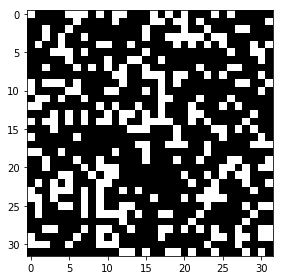

In [74]:
skimage.io.imshow(pp)

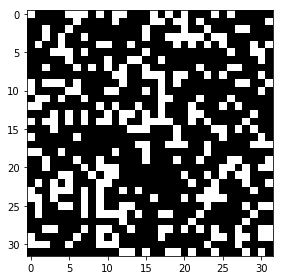

In [75]:
skimage.io.imshow(label[i,...,0])

In [77]:
(pp==label[i,...,0]).all()

True